In [2]:
!pip install pypots

In [3]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler

from pygrinder import mcar, seq_missing, block_missing
from pypots.imputation import SAITS

from pypots.utils.metrics import calc_mae, calc_mse, calc_mre

from scipy.interpolate import interp1d

import torch
import torch.nn as nn
from sklearn.impute import KNNImputer

from torch.utils.data import DataLoader, TensorDataset, random_split

from matplotlib.widgets import Slider
import ipywidgets as widgets
from ipywidgets import interact

from scipy.fft import fft
from scipy.ndimage import gaussian_filter


2025-04-24 13:50:04 [WARNING]: ‼️ `pypots.utils.metrics` is deprecated. Please import from `pypots.nn.functional` instead.



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



# load data and reprocessing

## load datas

In [4]:
instances_dict_path = 'instances_dict.json'
with open(instances_dict_path, 'r') as f:
    instances_dict = json.load(f)

smoothpur_1_4 = np.load(r'C:\Users\uefav\Desktop\Beca\Nistagmo_1_4.npy')
# smoothpur_5_8 = np.load('Artificial_data/SmoothPur_5_8.npy')
# smoothpur_9_10 = np.load('Artificial_data/SmoothPur_9_10.npy')
# smoothpur_11_12 = np.load('Artificial_data/SmoothPur_11_12.npy')

print(instances_dict)
print('length of instances_dict : ' ,len(instances_dict))
print('-' * 100)
print('length of smoothpur_1_4 : ' ,len(smoothpur_1_4))
# print('length of smoothpur_5_8 : ' ,len(smoothpur_5_8))
# print('length of smoothpur_9_10 : ' ,len(smoothpur_9_10))
# print('length of smoothpur_11_12 : ' ,len(smoothpur_11_12))
print('-' * 100)
print('type of smoothpur_1_4 : ' , type(smoothpur_1_4))
# print('type of smoothpur_5_8 : ' , type(smoothpur_5_8))
# print('type of smoothpur_9_10 : ' , type(smoothpur_9_10))
# print('type of smoothpur_11_12 : ' , type(smoothpur_11_12))
print('-' * 100)
print('shape of smoothpur_1_4 : ' , smoothpur_1_4.shape)
# print('shape of smoothpur_5_8 : ' , smoothpur_5_8.shape)
# print('shape of smoothpur_9_10 : ' , smoothpur_9_10.shape)
# print('shape of smoothpur_11_12 : ' , smoothpur_11_12.shape)

{'0': 'HF008_V2', '1': 'HF009_V2', '2': 'HF010_V2', '3': 'HF011_V2', '4': 'HF012_V2', '5': 'HF015_V2', '6': 'HF016_V2', '7': 'HF026_V2', '8': 'HF027_V2', '9': 'HF030_V2', '10': 'HF031_V2', '11': 'HF032_V2', '12': 'HF033_V2', '13': 'HG001_V2', '14': 'HG002_V2', '15': 'HG003_V2', '16': 'HG004_V2', '17': 'HG005_V2', '18': 'HG005_V3', '19': 'HG006_V2', '20': 'HG008_V2', '21': 'HG009_V2', '22': 'HG010_V2', '23': 'HG011_V2', '24': 'HG012_V2', '25': 'HG014_V2', '26': 'HG015_V2', '27': 'HG016_V2', '28': 'HG017_V2', '29': 'HG018_V2', '30': 'HG019_V2', '31': 'HG021_V2', '32': 'HG022_V2', '33': 'HG023_V2', '34': 'HG024_V2', '35': 'HG025_V2', '36': 'HG027_V2', '37': 'HG028_V2', '38': 'HG029_V2', '39': 'HG030_V2', '40': 'HG031_V2', '41': 'HG032_V2', '42': 'HG034_V2', '43': 'HG035_V2', '44': 'HG036_V2', '45': 'HG037_V2', '46': 'HG038_V2', '47': 'HG039_V2', '48': 'HG041_V2', '49': 'HG043_V2', '50': 'HG044_V2', '51': 'HG047_V2', '52': 'HG048_V2', '53': 'HG049_V2', '54': 'HG050_V2', '55': 'HG051_V2', '

## utility functions

In [5]:
def flatten_smoothpur_1_8(original_arr):
    arr_shape = original_arr.shape
    flattened_list = []
    for i in range(arr_shape[0]):
      for j in range(arr_shape[1]):
        flattened_list.append(original_arr[i][j][0])
        flattened_list.append(original_arr[i][j][1])
    flattened_arr = np.array(flattened_list)
    return flattened_arr

In [6]:
def reform_smoothpur_1_8(flattened_arr, original_arr):
    arr_shape = original_arr.shape
    reshaped_arr = flattened_arr.reshape((154, 4, 2, 15000))
    target_values = np.empty((154, 4, 1, 15000))
    for i in range(arr_shape[0]):
        for j in range(arr_shape[1]):
            target = original_arr[i][j][2]
            target_values[i][j][0] = target
    reformed_arr = np.concatenate((reshaped_arr, target_values), axis=2)
    return reformed_arr

In [7]:
def flatten_Target_1_8(original_arr):
    arr_shape = original_arr.shape
    flattened_list = []
    for i in range(arr_shape[0]):
      for j in range(arr_shape[1]):
        flattened_list.append(original_arr[i][j][2])
        flattened_list.append(original_arr[i][j][2])
    flattened_arr = np.array(flattened_list)
    return flattened_arr

In [8]:
def flatten_Target_9_12(original_arr):
    arr_shape = original_arr.shape
    flattened_x_list = []
    flattened_y_list = []
    for i in range(arr_shape[0]):
      for j in range(arr_shape[1]):
        flattened_x_list.append(original_arr[i][j][2][0])
        flattened_x_list.append(original_arr[i][j][2][0])
        flattened_y_list.append(original_arr[i][j][2][1])
        flattened_y_list.append(original_arr[i][j][2][1])
    flattened_x_arr = np.array(flattened_x_list)
    flattened_y_arr = np.array(flattened_y_list)
    return flattened_x_arr, flattened_y_arr

In [9]:
def reform_smoothpur_1_8_500(flattened_arr):
    reshaped_arr = flattened_arr.reshape((154, 4, 2, 500))
    return reshaped_arr

In [11]:
def flatten_smoothpur_9_12(original_arr):
    arr_shape = original_arr.shape
    flattened_x_list = []
    flattened_y_list = []
    for i in range(arr_shape[0]):
      for j in range(arr_shape[1]):
        flattened_x_list.append(original_arr[i][j][0][0])
        flattened_x_list.append(original_arr[i][j][0][1])
        flattened_y_list.append(original_arr[i][j][1][0])
        flattened_y_list.append(original_arr[i][j][1][1])
    flattened_x_arr = np.array(flattened_x_list)
    flattened_y_arr = np.array(flattened_y_list)
    return flattened_x_arr, flattened_y_arr

In [10]:
def reform_smoothpur_9_12(flattened_x_arr,flattened_y_arr, original_arr):
    arr_shape = original_arr.shape
    reshaped_x_arr = flattened_x_arr.reshape((154, 2, 1, 2, 15000))
    reshaped_y_arr = flattened_y_arr.reshape((154, 2, 1, 2, 15000))
    reformed_signal_arr = np.concatenate((reshaped_x_arr, reshaped_y_arr), axis=2)
    target_x_values = np.empty((154, 2, 1, 1, 15000))
    target_y_values = np.empty((154, 2, 1, 1, 15000))
    for i in range(arr_shape[0]):
        for j in range(arr_shape[1]):
            targetx = original_arr[i][j][2][0]
            targety = original_arr[i][j][2][1]
            target_x_values[i][j][0][0] = targetx
            target_y_values[i][j][0][0] = targety
    reformed_target_arr = np.concatenate((target_x_values, target_y_values), axis=3)
    total_reformed_arr = np.concatenate((reformed_signal_arr, reformed_target_arr), axis=2)
    return total_reformed_arr

In [12]:
def reform_smoothpur_9_12_500(flattened_x_arr,flattened_y_arr):
    reshaped_x_arr = flattened_x_arr.reshape((154, 2, 1, 2, 500))
    reshaped_y_arr = flattened_y_arr.reshape((154, 2, 1, 2, 500))
    reformed_signal_arr = np.concatenate((reshaped_x_arr, reshaped_y_arr), axis=2)
    return reformed_signal_arr

In [13]:
def downsample(signals, new_len):
    downsampled_signals = []
    for signal in signals:
        signal = signal.reshape(-1)  # Flatten the signal
        downsample_factor = len(signal) // new_len
        indices = np.arange(0, len(signal), downsample_factor)
        downsampled_signal = signal[indices[:new_len]]  # Ensure the length matches new_len
        downsampled_signals.append(downsampled_signal)
    return np.array(downsampled_signals)

In [14]:
def interpolation(downsampled_signals, target_length):
    upsampled_signals = []
    for signal in downsampled_signals:
        x_old = np.linspace(0, 1, len(signal))
        x_new = np.linspace(0, 1, target_length)
        interpolator = interp1d(x_old, signal, kind='cubic')
        upsampled_signal = interpolator(x_new)
        upsampled_signals.append(upsampled_signal)
    return np.array(upsampled_signals)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# Define the Autoencoder Model
import torch.nn.functional as F

class ImprovedAutoencoder(nn.Module):
    def __init__(self):
        super(ImprovedAutoencoder, self).__init__()
        # Encoder
        self.encoder_conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.encoder_bn1 = nn.BatchNorm1d(32)
        
        self.encoder_conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1)  # Downsample
        self.encoder_bn2 = nn.BatchNorm1d(64)
        
        self.encoder_conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)  # Downsample
        self.encoder_bn3 = nn.BatchNorm1d(128)
        
        self.encoder_conv4 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1)  # Downsample
        self.encoder_bn4 = nn.BatchNorm1d(256)
        
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.1)
    
        # Decoder
        self.decoder_convtrans1 = nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1)  # Upsample
        self.decoder_bn1 = nn.BatchNorm1d(128)
        
        self.decoder_convtrans2 = nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1)  # Upsample
        self.decoder_bn2 = nn.BatchNorm1d(64)
        
        self.decoder_convtrans3 = nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1)  # Upsample
        self.decoder_bn3 = nn.BatchNorm1d(32)
        
        self.decoder_conv1 = nn.Conv1d(32, 1, kernel_size=3, stride=1, padding=1)  # Output layer
        
    def forward(self, x):
        # Encoder
        x1 = self.encoder_conv1(x)
        x1 = self.encoder_bn1(x1)
        x1 = self.relu(x1)
        # x1 = self.dropout(x1)
        
        x2 = self.encoder_conv2(x1)
        x2 = self.encoder_bn2(x2)
        x2 = self.relu(x2)
        # x2 = self.dropout(x2)
        
        x3 = self.encoder_conv3(x2)
        x3 = self.encoder_bn3(x3)
        x3 = self.relu(x3)
        # x3 = self.dropout(x3)
        
        x4 = self.encoder_conv4(x3)
        x4 = self.encoder_bn4(x4)
        x4 = self.relu(x4)
        # x4 = self.dropout(x4)
        
        # Decoder
        x = self.decoder_convtrans1(x4)
        x = self.decoder_bn1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        # Add skip connection from x3
        if x3.size(2) != x.size(2):
            x3 = F.interpolate(x3, size=x.size(2))
        x = x + x3
        
        x = self.decoder_convtrans2(x)
        x = self.decoder_bn2(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        # Add skip connection from x2
        if x2.size(2) != x.size(2):
            x2 = F.interpolate(x2, size=x.size(2))
        x = x + x2
        
        x = self.decoder_convtrans3(x)
        x = self.decoder_bn3(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        # Add skip connection from x1
        if x1.size(2) != x.size(2):
            x1 = F.interpolate(x1, size=x.size(2))
        x = x + x1
        
        # Output layer
        x = self.decoder_conv1(x)
        return x
# Instantiate the model
model = ImprovedAutoencoder()

model.load_state_dict(torch.load('best_improved_autoencoder_1500.pth'))
model.to(device)

cpu


ImprovedAutoencoder(
  (encoder_conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_conv2): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (encoder_bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_conv3): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (encoder_bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_conv4): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
  (encoder_bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (decoder_convtrans1): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,))
  (decoder_bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_convtrans2): ConvTranspose1d(128, 64, kernel_size=

In [16]:
def plot_signal_comparison(original_signals, interpolated_signals, refined_signals):
    def plot_signal(signal_idx):
        original_signal = original_signals[signal_idx]
        interpolated_signal = interpolated_signals[signal_idx]
        refined_signal = refined_signals[signal_idx]

        plt.figure(figsize=(18, 8))
        plt.plot(original_signal.flatten(), label='Original Signal', alpha=0.7, color='blue', linewidth=2)
        plt.plot(interpolated_signal.flatten(), label='Interpolated Signal', alpha=0.7, color='orange')
        plt.plot(refined_signal.flatten(), label='Refined Signal', alpha=0.7, color='green')

        plt.title(f'Signal Comparison for Index {signal_idx}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()

    interact(plot_signal, signal_idx=widgets.IntSlider(min=0, max=len(original_signals)-1, step=1, value=0))

In [17]:
def mask_nan_values(original_signals, replacement_signals):
    sigma=1
    masked_signals = []
    for orig_signal, repl_signal in zip(original_signals, replacement_signals):
        if orig_signal.shape != repl_signal.shape:
            raise ValueError("Original and replacement signals must have the same shape.")
        
        masked_signal = np.array(orig_signal)
        mask = np.isnan(orig_signal)
        masked_signal[mask] = repl_signal[mask]
        
        # Apply Gaussian smoothing
        masked_signal = gaussian_filter(masked_signal, sigma=sigma)
        
        masked_signals.append(masked_signal)
        
    return np.array(masked_signals)


In [18]:
def cubic_interpolation_imputation(signals):
    """
    Impute missing values in signals using cubic interpolation.

    Parameters:
    - signals: numpy array of shape (n_signals, n_samples) containing NaNs at positions to impute.

    Returns:
    - imputed_signals: numpy array of same shape as signals, with NaNs replaced by imputed values.
    """
    n_signals, n_samples = signals.shape
    imputed_signals = np.empty_like(signals)

    for i in range(n_signals):
        signal = signals[i, :]
        x = np.arange(n_samples)
        y = signal

        # Indices where y is not NaN
        valid_mask = ~np.isnan(y)
        invalid_mask = np.isnan(y)

        if np.sum(valid_mask) < 2:
            # Not enough valid points to interpolate; copy the original signal
            imputed_signals[i, :] = signal
            continue

        # Check if there are enough points for cubic interpolation
        if np.sum(valid_mask) < 4:
            # Use linear interpolation if not enough points for cubic
            interp_kind = 'linear'
        else:
            interp_kind = 'cubic'

        # Perform interpolation
        interp_func = interp1d(
            x[valid_mask], y[valid_mask], kind=interp_kind, bounds_error=False, fill_value="extrapolate"
        )

        # Interpolate at all positions
        y_interp = interp_func(x)

        # Replace NaNs with interpolated values
        imputed_signal = np.copy(signal)
        imputed_signal[invalid_mask] = y_interp[invalid_mask]

        imputed_signals[i, :] = imputed_signal

    return imputed_signals

In [19]:
def refine_signals(interpolated_results, model, device):
    # Convert the interpolated results to a tensor
        
    interpolated_tensor = torch.tensor(interpolated_results, dtype=torch.float32)
    
    # Create a dataset and dataloader
    interpolated_dataset = TensorDataset(interpolated_tensor)
    interpolated_dataloader = DataLoader(interpolated_dataset, batch_size=32, shuffle=False)

    # Model evaluation mode
    model.eval()
    
    refined_signals = []
    
    with torch.no_grad():
        # Process the data using the model
        for data in interpolated_dataloader:
            data = data[0].unsqueeze(1).to(device)
            outputs = model(data)
            refined_signals.append(outputs.cpu().numpy())
    
    # Concatenate and squeeze the refined signals
    refined_signals = np.concatenate(refined_signals, axis=0)
    refined_signals = np.squeeze(refined_signals, axis=1)
    
    return refined_signals

In [20]:
def Refinement_nan_pipeline(original_data, imputation_method, SAITS_model, Target, refinement_model, device):
    # Flatten and downsample the input data
    downsampled_data = downsample(original_data, 500)

    # Impute missing values using the specified imputation method
    if imputation_method == 'SSA':
        imputed_results = ssa_imputation_for_signal(downsampled_data, Target)
    elif imputation_method == 'Cubic':
        imputed_results = cubic_interpolation_imputation(downsampled_data)
    elif imputation_method == 'SAITS':
        imputed_results = imputation_SAITS(downsampled_data, SAITS_model)
    elif imputation_method == 'KNN':
        imputed_results = knn_imputation(downsampled_data)
    else:
        raise ValueError(f"Unrecognized imputation method: {imputation_method}")

    # Reform and interpolate the results
    interpolated_data = interpolation(imputed_results, 15000)
   
    # Refine signals using the refinement model
    refined_data = refine_signals(interpolated_data, refinement_model, device)

    # Mask NaN values in the interpolated and refined results
    masked_interpolated_data = mask_nan_values(original_data, interpolated_data)
    masked_refined_data = mask_nan_values(original_data, refined_data)

    return masked_interpolated_data, masked_refined_data


In [21]:
def calculate_metrics(predicted_signals, original_signals, indicating_mask):
    
    # Apply the mask to filter out only the points where we want to calculate the metrics
    masked_predicted = predicted_signals[indicating_mask]
    masked_original = original_signals[indicating_mask]

    # Calculate MAE
    mae = np.mean(np.abs(masked_predicted - masked_original))

    # Calculate MSE
    mse = np.mean((masked_predicted - masked_original) ** 2)

    # Calculate MRE (Mean Relative Error), avoid division by zero
    # nonzero_mask = masked_original != 0
    # mre = np.mean(np.abs((masked_predicted[nonzero_mask] - masked_original[nonzero_mask]) / masked_original[nonzero_mask]))
   # Modify MRE calculation to match SAITS
    mre = np.sum(np.abs(masked_predicted - masked_original)) / np.sum(np.abs(masked_original) + 1e-12)

    return mae, mse, mre


In [22]:
def compute_all_metrics(imputed_signal, original_signal, indicating_mask):
    
    num_signals, signal_length = original_signal.shape
    high_freq=30
    low_freq=0.1
    sampling_rate=1000

    # Initialize lists to store metrics for each signal
    MAE_list = []
    MRE_list = []
    RMSE_list = []
    Sim_list = []
    FSD_list = []
    RMSE_F_list = []
    RMSE_F_low_list = []
    RMSE_F_high_list = []

    # Define frequency bins for low and high frequencies
    freq_bins = np.fft.rfftfreq(signal_length, d=1/sampling_rate)
    low_freq_indices = np.where(freq_bins <= low_freq)[0]
    high_freq_indices = np.where(freq_bins >= high_freq)[0]

    # Loop over each signal
    for i in range(num_signals):
        orig_sig = original_signal[i, :]
        imp_sig = imputed_signal[i, :]
        mask = indicating_mask[i, :]

        # Ensure signals are 1D arrays
        orig_sig = np.ravel(orig_sig)
        imp_sig = np.ravel(imp_sig)
        mask = np.ravel(mask)

        # If there are no imputed positions in this signal, skip evaluation
        if not np.any(mask):
            continue

        # Extract the values at the imputed positions
        orig_values_at_imputed = orig_sig[mask]
        imp_values_at_imputed = imp_sig[mask]

        # Time Domain Metrics
        # MAE
        mae = np.mean(np.abs(orig_values_at_imputed - imp_values_at_imputed))
        MAE_list.append(mae)

        # MRE
        with np.errstate(divide='ignore', invalid='ignore'):
            relative_errors = np.abs((orig_values_at_imputed - imp_values_at_imputed) / orig_values_at_imputed)
            relative_errors = np.nan_to_num(relative_errors, nan=0.0, posinf=0.0, neginf=0.0)
        mre = np.mean(relative_errors)
        MRE_list.append(mre)

        # RMSE
        mse = np.mean((orig_values_at_imputed - imp_values_at_imputed) ** 2)
        rmse = np.sqrt(mse)
        RMSE_list.append(rmse)

        # Similarity Metric (Sim)
        orig_mean = np.mean(orig_values_at_imputed)
        imp_mean = np.mean(imp_values_at_imputed)
        numerator = np.sum((orig_values_at_imputed - orig_mean) * (imp_values_at_imputed - imp_mean))
        denominator = np.sqrt(np.sum((orig_values_at_imputed - orig_mean) ** 2) * np.sum((imp_values_at_imputed - imp_mean) ** 2))
        sim = numerator / denominator if denominator != 0 else 0
        Sim_list.append(sim)

        # Fraction of Standard Deviation (FSD)
        std_orig = np.std(orig_values_at_imputed)
        fsd = rmse / std_orig if std_orig != 0 else 0
        FSD_list.append(fsd)

        # Frequency Domain Metrics
        # Compute FFTs of the entire signals
        orig_sig_fft = fft(orig_sig)
        imp_sig_fft = fft(imp_sig)

        # Compute RMSE in frequency domain (entire frequency range)
        mse_f = np.mean(np.abs(orig_sig_fft - imp_sig_fft) ** 2)
        rmse_f = np.sqrt(mse_f)
        RMSE_F_list.append(rmse_f)

        # RMSE in Low Frequencies (RMSE_F_low)
        orig_sig_fft_low = orig_sig_fft[low_freq_indices]
        imp_sig_fft_low = imp_sig_fft[low_freq_indices]
        mse_f_low = np.mean(np.abs(orig_sig_fft_low - imp_sig_fft_low) ** 2)
        rmse_f_low = np.sqrt(mse_f_low)
        RMSE_F_low_list.append(rmse_f_low)

        # RMSE in High Frequencies (RMSE_F_high)
        orig_sig_fft_high = orig_sig_fft[high_freq_indices]
        imp_sig_fft_high = imp_sig_fft[high_freq_indices]
        mse_f_high = np.mean(np.abs(orig_sig_fft_high - imp_sig_fft_high) ** 2)
        rmse_f_high = np.sqrt(mse_f_high)
        RMSE_F_high_list.append(rmse_f_high)

    # Aggregate metrics
    metrics = {
        'MAE_mean': np.mean(MAE_list) if MAE_list else None,
        # 'MAE_std': np.std(MAE_list),
        'MRE_mean': np.mean(MRE_list) if MRE_list else None,
        # 'MRE_std': np.std(MRE_list),
        'RMSE_mean': np.mean(RMSE_list) if RMSE_list else None,
        # 'RMSE_std': np.std(RMSE_list),
        'Sim_mean': np.mean(Sim_list) if Sim_list else None,
        # 'Sim_std': np.std(Sim_list),
        'FSD_mean': np.mean(FSD_list) if FSD_list else None,
        # 'FSD_std': np.std(FSD_list),
        'RMSE_F_mean': np.mean(RMSE_F_list) if RMSE_F_list else None,
         # 'RMSE_F_std': np.std(RMSE_F_list),
        'RMSE_F_Low_mean': np.mean(RMSE_F_low_list) if RMSE_F_low_list else None,
        # 'RMSE_F_Low_std': np.std(RMSE_F_low_list),
        'RMSE_F_High_mean': np.mean(RMSE_F_high_list) if RMSE_F_high_list else None,
        # 'RMSE_F_High_std': np.std(RMSE_F_high_list)
    }

    return metrics

In [23]:
def modified_ssa_imputation(signal_with_blinks, target):
    """
    Impute missing values in the entire signal_with_blinks using Modified SSA.

    Parameters:
    - signal_with_blinks: 1D numpy array with the data to impute. Blinks must be NaNs.
    - target: 1D numpy array representing the stimulus or target signal.

    Returns:
    - imputed_signal: The signal with NaNs imputed (numpy array).
    """
    # Set length_limit (can be adjusted based on your data characteristics)
    length_limit = 60  # or any other appropriate value

    # Copy the signal to avoid modifying the original
    imputed_signal = signal_with_blinks.copy()
    time_series = signal_with_blinks.copy()

    # Find indices where time_series is NaN
    nan_indices = np.isnan(time_series)

    # Find start and end indices of each NaN segment
    gaps = []
    i = 0
    n = len(time_series)
    while i < n:
        if nan_indices[i]:
            inicioCurrentEvent = i
            while i < n and nan_indices[i]:
                i += 1
            finCurrentEvent = i - 1
            gaps.append((inicioCurrentEvent, finCurrentEvent))
        else:
            i += 1

    # For each gap, perform imputation using Modified SSA
    for inicioCurrentEvent, finCurrentEvent in gaps:
        imputed_values = ssa_impute_gap(time_series, inicioCurrentEvent, finCurrentEvent, length_limit, target)
        # Update imputed_signal with imputed_values
        imputed_signal[inicioCurrentEvent:finCurrentEvent+1] = imputed_values

    return imputed_signal

def ssa_impute_gap(time_series, inicioCurrentEvent, finCurrentEvent, length_limit, target):
    """
    Impute a single gap using Modified SSA.

    Parameters:
    - time_series: Original time series with NaNs.
    - inicioCurrentEvent: Start index of the gap.
    - finCurrentEvent: End index of the gap.
    - length_limit: Limit for the length of the front and back segments.
    - target: Target signal for augmentation.

    Returns:
    - imputed_values: Imputed values for the gap.
    """
    Ngap = finCurrentEvent - inicioCurrentEvent + 1  # Size of the gap

    # Find previous non-NaN segment before the gap
    prev_non_nan = inicioCurrentEvent - 1
    while prev_non_nan >= 0 and np.isnan(time_series[prev_non_nan]):
        prev_non_nan -= 1

    # Find next non-NaN segment after the gap
    next_non_nan = finCurrentEvent + 1
    while next_non_nan < len(time_series) and np.isnan(time_series[next_non_nan]):
        next_non_nan += 1

    # Normalization
    meanTimeSeries = np.nanmean(time_series)
    stdTimeSeries = np.nanstd(time_series)
    if stdTimeSeries == 0:
        stdTimeSeries = 1  # Avoid division by zero
    time_series_norm = (time_series - meanTimeSeries) / stdTimeSeries

    stdTarget = np.nanstd(target)
    if stdTarget == 0:
        stdTarget = 1
    target_norm = (target - np.nanmean(target)) / stdTarget

    # Prepare front (data before the gap)
    if prev_non_nan >= 0:
        front = time_series_norm[max(0, prev_non_nan - length_limit + 1):prev_non_nan + 1]
    else:
        front = np.array([])
    
    # Remove any NaNs in front
    front = front[~np.isnan(front)]

    # Prepare back (data after the gap)
    if next_non_nan < len(time_series):
        back = time_series_norm[next_non_nan:min(len(time_series), next_non_nan + length_limit)]
    else:
        back = np.array([])

    # Remove any NaNs in back
    back = back[~np.isnan(back)]

    # Augment with target if insufficient data
    if len(front) < length_limit:
        n_needed = length_limit - len(front)
        # Get data from target prior to the gap
        target_start_idx = max(0, inicioCurrentEvent - n_needed)
        target_end_idx = inicioCurrentEvent
        target_segment = target_norm[target_start_idx:target_end_idx]
        front = np.concatenate((target_segment, front))

    if len(back) < length_limit:
        n_needed = length_limit - len(back)
        # Get data from target after the gap
        target_start_idx = finCurrentEvent + 1
        target_end_idx = min(len(target_norm), target_start_idx + n_needed)
        target_segment = target_norm[target_start_idx:target_end_idx]
        back = np.concatenate((back, target_segment))

    nf = len(front)
    nb = len(back)

    # Step 2: Utilize SSA Technique
    data_r = None
    if nf > 1:
        try:
            L = min(450, nf - 1)
            N = int(0.25 * L)
            data_r = ssafor(front, L, N, Ngap)  # Forward SSA
        except Exception as e:
            data_r = None

    data_s = None
    if nb > 1:
        try:
            L = min(450, nb - 1)
            N = int(0.25 * L)
            data_s = ssafor(back[::-1], L, N, Ngap)  # Reverse SSA
            data_s = data_s[::-1]  # Revert to original order
        except Exception as e:
            data_s = None

    # Step 3: Weighting
    weights_backcast = np.linspace(0, 1, Ngap)
    weights_forecast = weights_backcast[::-1]

    # Step 4: Calculate interpolation
    # Linear interpolation as fallback
    xIn = []
    dataIn = []
    if nf > 0:
        xIn.extend([inicioCurrentEvent - nf + i for i in range(nf)])
        dataIn.extend(front)
    if nb > 0:
        xIn.extend([finCurrentEvent + 1 + i for i in range(nb)])
        dataIn.extend(back)
    xBuscado = [inicioCurrentEvent + i for i in range(Ngap)]
    if len(xIn) > 1:
        vinterp = np.interp(xBuscado, xIn, dataIn)
    else:
        # If not enough points for interpolation, use mean
        vinterp = np.full(Ngap, np.nanmean(time_series_norm))

    var_ts = np.nanvar(time_series_norm)

    # Conditions to decide which data to use
    if data_s is None or np.isnan(data_s).any():
        data_s = vinterp
    if data_r is None or np.isnan(data_r).any():
        data_r = vinterp

    # Combine SSA forecasts using weights
    if data_s is not None and data_r is not None:
        meanMatrix = data_s * weights_backcast + data_r * weights_forecast
    else:
        meanMatrix = vinterp

    # Unnormalization
    imputed_values = meanMatrix * stdTimeSeries + meanTimeSeries

    return imputed_values

def ssafor(Y, L, N, M):
    """
    SSA Forecasting function.

    Parameters:
    - Y: Input time series (1D numpy array).
    - L: Window length.
    - N: Number of eigenvectors to use.
    - M: Number of points to forecast.

    Returns:
    - F: Forecasted values (numpy array).
    """
    Y = np.array(Y).flatten()
    T = len(Y)
    K = T - L + 1

    # Embedding
    X = np.column_stack([Y[i:i+K] for i in range(L)])

    # Singular Value Decomposition
    U, s, Vt = np.linalg.svd(X, full_matrices=False)

    # Reconstruct time series using N components
    X_reconstructed = np.zeros_like(X)
    for i in range(N):
        X_reconstructed += s[i] * np.outer(U[:, i], Vt[i, :])

    # Diagonal averaging
    reconstructed_series = np.zeros(T)
    weight = np.zeros(T)
    for i in range(-L+1, K):
        diag_elements = np.diag(X_reconstructed, k=i)
        idx = max(0, i + L - 1)
        reconstructed_series[idx:idx + len(diag_elements)] += diag_elements
        weight[idx:idx + len(diag_elements)] += 1
    reconstructed_series /= weight

    # Forecasting
    # Build the forecasting matrix
    F = np.copy(reconstructed_series)
    for i in range(M):
        # Predict next value using last L-1 values
        if len(F) >= L:
            last_values = F[-(L-1):]
        else:
            last_values = np.hstack((np.zeros(L - 1 - len(F)), F))
        # Use coefficients from reconstructed components
        coeffs = np.polyfit(np.arange(len(last_values)), last_values, N - 1)
        next_value = np.polyval(coeffs, len(last_values))
        F = np.append(F, next_value)

    F = F[T:]
    return F

In [24]:
def ssa_imputation_for_signal(signals_with_blinks, targets):
    """
    Impute missing values for all signals using Modified SSA.

    Parameters:
    - signals_with_blinks: List of 1D numpy arrays, each with the data to impute. Blinks must be NaNs.
    - targets: List of 1D numpy arrays representing the stimulus or target signals corresponding to each signal.

    Returns:
    - imputed_signals: List of signals with NaNs imputed (list of numpy arrays).
    """
    imputed_signals = []
    for signal_with_blinks, target in zip(signals_with_blinks, targets):
        imputed_signal = modified_ssa_imputation(signal_with_blinks, target)
        imputed_signals.append(imputed_signal)
    return imputed_signals


In [25]:
def knn_imputation(signals):
    """
    Impute missing values in signals using K-Nearest Neighbors (KNN) imputation.

    Parameters:
    - signals: numpy array of shape (n_signals, n_samples) with NaN values.
    - n_neighbors: number of neighbors to use for KNN imputation (default is 7).

    Returns:
    - imputed_signals: numpy array of same shape as signals with NaNs replaced by imputed values.
    """

    n_neighbors=7
    # Create KNN imputer instance
    imputer = KNNImputer(n_neighbors=n_neighbors)
    
    # Fit the imputer and transform the data
    imputed_signals = imputer.fit_transform(signals)

    return imputed_signals




In [26]:
flat_1_4 = flatten_smoothpur_1_8(smoothpur_1_4)
# flat_5_8 = flatten_smoothpur_1_8(smoothpur_5_8)
# flat_x_9_10, flat_y_9_10 = flatten_smoothpur_9_12(smoothpur_9_10)
# flat_x_11_12, flat_y_11_12 = flatten_smoothpur_9_12(smoothpur_11_12)

mean_1_4 = np.nanmean(flat_1_4)
std_1_4 = np.nanstd(flat_1_4)
flat_1_4_normalized = (flat_1_4 - mean_1_4) / std_1_4
# flat_1_4_normalized = min_max_normalize(flat_1_4)

# mean_5_8 = np.nanmean(flat_5_8)
# std_5_8 = np.nanstd(flat_5_8)
# flat_5_8_normalized = (flat_5_8 - mean_5_8) / std_5_8
# # flat_5_8_normalized = min_max_normalize(flat_5_8)



# mean_y_9_10 = np.nanmean(flat_y_9_10)
# std_y_9_10 = np.nanstd(flat_y_9_10)
# flat_y_9_10_normalized = (flat_y_9_10 - mean_y_9_10) / std_y_9_10
# # flat_y_9_10_normalized = min_max_normalize(flat_y_9_10)

# mean_x_11_12 = np.nanmean(flat_x_11_12)
# std_x_11_12 = np.nanstd(flat_x_11_12)
# flat_x_11_12_normalized = (flat_x_11_12 - mean_x_11_12) / std_x_11_12
# # flat_x_11_12_normalized = min_max_normalize(flat_x_11_12)

# mean_y_11_12 = np.nanmean(flat_y_11_12)
# std_y_11_12 = np.nanstd(flat_y_11_12)
# flat_y_11_12_normalized = (flat_y_11_12 - mean_y_11_12) / std_y_11_12
# # flat_y_11_12_normalized = min_max_normalize(flat_y_11_12)

print('shape of flattened smoothpur_1_4 :', flat_1_4_normalized.shape)
# print('shape of flattened smoothpur_5_8 :', flat_5_8_normalized.shape)
# print('shape of flattened smoothpur_x_9_10 :', flat_x_9_10_normalized.shape)
# print('shape of flattened smoothpur_y_9_10 :', flat_y_9_10_normalized.shape)
# print('shape of flattened smoothpur_x_11_12 :', flat_x_11_12_normalized.shape)
# print('shape of flattened smoothpur_y_11_12 :', flat_y_11_12_normalized.shape)

shape of flattened smoothpur_1_4 : (576, 15000)


In [27]:
flat_1_4 = flatten_smoothpur_1_8(smoothpur_1_4)
# flat_5_8 = flatten_smoothpur_1_8(smoothpur_5_8)
# flat_x_9_10, flat_y_9_10 = flatten_smoothpur_9_12(smoothpur_9_10)
# flat_x_11_12, flat_y_11_12 = flatten_smoothpur_9_12(smoothpur_11_12)

mean_1_4 = np.nanmean(flat_1_4)
std_1_4 = np.nanstd(flat_1_4)
flat_1_4_normalized = (flat_1_4 - mean_1_4) / std_1_4
# flat_1_4_normalized = min_max_normalize(flat_1_4)

# mean_5_8 = np.nanmean(flat_5_8)
# std_5_8 = np.nanstd(flat_5_8)
# flat_5_8_normalized = (flat_5_8 - mean_5_8) / std_5_8
# # flat_5_8_normalized = min_max_normalize(flat_5_8)



# mean_y_9_10 = np.nanmean(flat_y_9_10)
# std_y_9_10 = np.nanstd(flat_y_9_10)
# flat_y_9_10_normalized = (flat_y_9_10 - mean_y_9_10) / std_y_9_10
# # flat_y_9_10_normalized = min_max_normalize(flat_y_9_10)

# mean_x_11_12 = np.nanmean(flat_x_11_12)
# std_x_11_12 = np.nanstd(flat_x_11_12)
# flat_x_11_12_normalized = (flat_x_11_12 - mean_x_11_12) / std_x_11_12
# # flat_x_11_12_normalized = min_max_normalize(flat_x_11_12)

# mean_y_11_12 = np.nanmean(flat_y_11_12)
# std_y_11_12 = np.nanstd(flat_y_11_12)
# flat_y_11_12_normalized = (flat_y_11_12 - mean_y_11_12) / std_y_11_12
# # flat_y_11_12_normalized = min_max_normalize(flat_y_11_12)

print('shape of flattened smoothpur_1_4 :', flat_1_4_normalized.shape)
# print('shape of flattened smoothpur_5_8 :', flat_5_8_normalized.shape)
# print('shape of flattened smoothpur_x_9_10 :', flat_x_9_10_normalized.shape)
# print('shape of flattened smoothpur_y_9_10 :', flat_y_9_10_normalized.shape)
# print('shape of flattened smoothpur_x_11_12 :', flat_x_11_12_normalized.shape)
# print('shape of flattened smoothpur_y_11_12 :', flat_y_11_12_normalized.shape)

shape of flattened smoothpur_1_4 : (576, 15000)


In [28]:
flats_normalized = np.concatenate([
    flat_1_4_normalized,
    # flat_5_8_normalized,
    # flat_x_9_10_normalized,
    # flat_y_9_10_normalized,
    # flat_x_11_12_normalized,
    # flat_y_11_12_normalized
], axis=0)


In [29]:
down_1_4 = downsample(flat_1_4_normalized, 500)
# down_5_8 = downsample(flat_5_8_normalized, 500)
# down_x_9_10, down_y_9_10 = downsample(flat_x_9_10_normalized, 500), downsample(flat_y_9_10_normalized, 500)
# down_x_11_12, down_y_11_12 = downsample(flat_x_11_12_normalized, 500), downsample(flat_y_11_12_normalized, 500)
downs = downsample(flats_normalized, 500)


print('shape of downsampled smoothpur_1_4 :', down_1_4.shape)
# print('shape of downsampled smoothpur_5_8 :', down_5_8.shape)
# print('shape of downsampled smoothpur_x_9_10 :', down_x_9_10.shape)
# print('shape of downsampled smoothpur_y_9_10 :', down_y_9_10.shape)
# print('shape of downsampled smoothpur_x_11_12 :', down_x_11_12.shape)
# print('shape of downsampled smoothpur_y_11_12 :', down_y_11_12.shape)
print('shape of downsampled All smoothpurs :', downs.shape)

shape of downsampled smoothpur_1_4 : (576, 500)
shape of downsampled All smoothpurs : (576, 500)


# edit from here

In [30]:
exp_1_4 = np.expand_dims(down_1_4, axis=-1)
# exp_5_8 = np.expand_dims(down_5_8, axis=-1)
# exp_x_9_10 = np.expand_dims(down_x_9_10, axis=-1)
# exp_y_9_10 = np.expand_dims(down_y_9_10, axis=-1)
# exp_x_11_12 = np.expand_dims(down_x_11_12, axis=-1)
# exp_y_11_12 = np.expand_dims(down_y_11_12, axis=-1)
exps = np.expand_dims(downs, axis=-1)


print('shape of expanded smoothpur_1_4 :', exp_1_4.shape)
# print('shape of expanded smoothpur_5_8 :', exp_5_8.shape)
# print('shape of expanded smoothpur_x_9_10 :', exp_x_9_10.shape)
# print('shape of expanded smoothpur_y_9_10 :', exp_y_9_10.shape)
# print('shape of expanded smoothpur_x_11_12 :', exp_x_11_12.shape)
# print('shape of expanded smoothpur_y_11_12 :', exp_y_11_12.shape)
print('shape of expanded All smoothpur :', exps.shape)

shape of expanded smoothpur_1_4 : (576, 500, 1)
shape of expanded All smoothpur : (576, 500, 1)


# SAITS

In [31]:
mask_rate = 0.3

In [32]:
from pypots.optim import Adam

# Define your custom optimizer
custom_optimizer = Adam(lr=0.0006)  # Set your desired learning rate

## All SAITS

In [33]:
%%time

X_ori = exps
np.random.seed(42)
torch.manual_seed(42)
X = mcar(exps, mask_rate)

dataset = {"X": X}

saits = SAITS(n_steps=500, n_features=1, n_layers=2, d_model=256, n_heads=4, d_k=64, d_v=64, d_ffn=128, dropout=0.2, epochs=3, optimizer=custom_optimizer)
saits.fit(dataset)
imputation = saits.impute(dataset)

indicating_mask = np.isnan(X) ^ np.isnan(X_ori)

saits.save(r'C:\Users\uefav\Desktop\Beca\saits_all_3.pypots', overwrite=True)
saits.load(r'C:\Users\uefav\Desktop\Beca\saits_all_3.pypots')

mae, mse, mre = calculate_metrics(imputation, np.nan_to_num(X_ori), indicating_mask)

print('MAE: ', mae, 'MSE:', mse, 'MRE: ', mre)

2025-04-24 13:51:38 [INFO]: No given device, using default device: cpu
2025-04-24 13:51:38 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-04-24 13:51:38 [INFO]: Using customized MAE as the training loss function.
2025-04-24 13:51:38 [INFO]: Using customized MSE as the validation metric function.
2025-04-24 13:51:38 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,318,906
2025-04-24 13:52:16 [INFO]: Epoch 001 - training loss (MAE): 0.8997
2025-04-24 13:52:59 [INFO]: Epoch 002 - training loss (MAE): 0.4070
2025-04-24 13:53:43 [INFO]: Epoch 003 - training loss (MAE): 0.3240
2025-04-24 13:53:43 [INFO]: Finished training. The best model is from epoch#3.
2025-04-24 13:54:01 [WARNING]: ‼️ File C:\Users\uefav\Desktop\Beca\saits_all_3.pypots exists. Argument `overwrite` is True. Overwriting now...
2025-04-24 13:54:01 [INFO]: Saved the model to C:\Users\uefav\Desktop\Beca\saits_all_3.pypots
2025-04-24 1

MAE:  0.17694525376213818 MSE: 0.05411325636895953 MRE:  0.19368691254278797
CPU times: total: 9min 9s
Wall time: 2min 23s


In [34]:

# X_ori = exps
# np.random.seed(42)
# torch.manual_seed(42)
# X = mcar(exps, mask_rate)

# dataset = {"X": X}

# saits = SAITS(n_steps=500, n_features=1, n_layers=2, d_model=256, n_heads=4, d_k=64, d_v=64, d_ffn=128, dropout=0.2, epochs=500, optimizer=custom_optimizer)
# imputation = saits.impute(dataset)

# indicating_mask = np.isnan(X) ^ np.isnan(X_ori)

# metrics_SAITS = compute_all_metrics(np.squeeze(imputation), np.squeeze(np.nan_to_num(X_ori)), np.squeeze(indicating_mask))


# # Print the results
# print("All SPT:")
# print('-' * 70)
# print("Computed Metrics Saits :")
# for key, value in metrics_SAITS.items():
#     print(f"{key}: {value:.4f}")

In [35]:
saits = SAITS(n_steps=500, n_features=1, n_layers=2, d_model=256, n_heads=4, d_k=64, d_v=64, d_ffn=128, dropout=0.2, epochs=500, optimizer=custom_optimizer)

saits.load(r'C:\Users\uefav\Desktop\Beca\saits_all_3.pypots')

2025-04-24 13:54:02 [INFO]: No given device, using default device: cpu
2025-04-24 13:54:02 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-04-24 13:54:02 [INFO]: Using customized MAE as the training loss function.
2025-04-24 13:54:02 [INFO]: Using customized MSE as the validation metric function.
2025-04-24 13:54:02 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,318,906
2025-04-24 13:54:02 [INFO]: Model loaded successfully from C:\Users\uefav\Desktop\Beca\saits_all_3.pypots


In [36]:
%%time

datasets = {"X": exps}
results_all = saits.impute(datasets)

print('shape of results smoothpur_all :', results_all.shape)

shape of results smoothpur_all : (576, 500, 1)
CPU times: total: 56 s
Wall time: 14.7 s


In [37]:
reshaped_results_all = np.squeeze(results_all)

print('shape of reshaped results smoothpur_all :', reshaped_results_all.shape)

shape of reshaped results smoothpur_all : (576, 500)


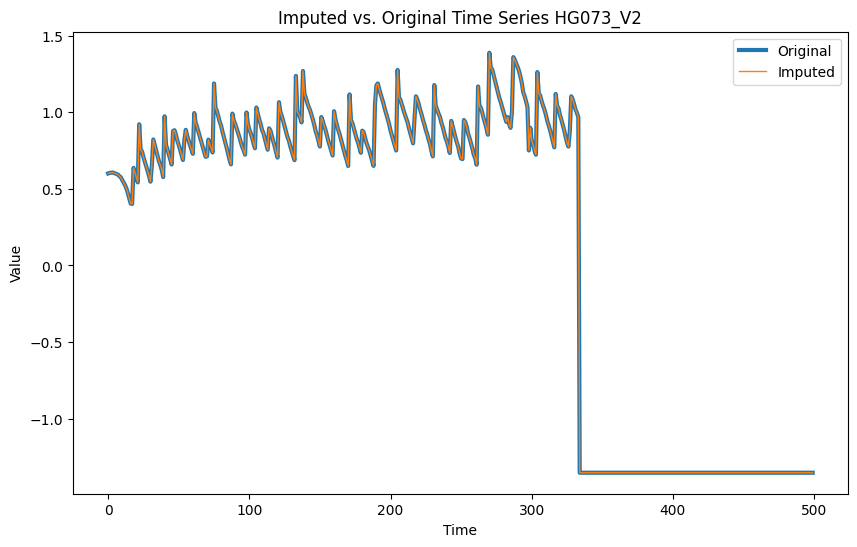

In [38]:
instance = 70

plt.figure(figsize=(10, 6))
plt.plot(downs[575], label='Original', linewidth=3)
plt.plot(reshaped_results_all[575], label='Imputed', linestyle='-', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Imputed vs. Original Time Series {instances_dict[str(instance)]}')
plt.legend()
plt.show()

# continue

## interpolation

In [39]:
interpolated_results_all = interpolation(reshaped_results_all, 15000)

print('shape of interpolated results All smoothpur :', interpolated_results_all.shape)

shape of interpolated results All smoothpur : (576, 15000)


## refining

In [40]:
refined_results_all = refine_signals(interpolated_results_all, model, device)

print('shape of refined results  All smoothpur :', refined_results_all.shape)

shape of refined results  All smoothpur : (576, 15000)


In [41]:
np.save(r'C:\Users\uefav\Desktop\Beca\refined_results_all.npy', refined_results_all)

refined_results_all = np.load(r'C:\Users\uefav\Desktop\Beca\refined_results_all.npy')

In [42]:
plot_signal_comparison(flats_normalized, interpolated_results_all, refined_results_all)

interactive(children=(IntSlider(value=0, description='signal_idx', max=575), Output()), _dom_classes=('widget-…

## generate masked signals

In [43]:
masked_interpolated_results_all = mask_nan_values(flats_normalized, interpolated_results_all)

masked_refined_results_all = mask_nan_values(flats_normalized, refined_results_all)

print('shape of masked interpolated results All smoothpurs :', masked_interpolated_results_all.shape)
print('shape of masked refined results All smoothpurs :', masked_refined_results_all.shape)

shape of masked interpolated results All smoothpurs : (576, 15000)
shape of masked refined results All smoothpurs : (576, 15000)


In [44]:
plot_signal_comparison(flats_normalized, masked_interpolated_results_all, masked_refined_results_all)

interactive(children=(IntSlider(value=0, description='signal_idx', max=575), Output()), _dom_classes=('widget-…

In [45]:
Target_1_4 = flatten_Target_1_8(smoothpur_1_4)
# Target_5_8 = flatten_Target_1_8(smoothpur_5_8)
# Target_x_9_10, Target_y_9_10= flatten_Target_9_12(smoothpur_9_10)
# Target_x_11_12, Target_y_11_12= flatten_Target_9_12(smoothpur_11_12)


In [46]:
mean_T_1_4 = np.nanmean(Target_1_4)
std_T_1_4 = np.nanstd(Target_1_4)
Target_1_4_n = (Target_1_4 - mean_T_1_4) / std_T_1_4
# Target_1_4_n = min_max_normalize(Target_1_4)


# mean_T_5_8= np.nanmean(Target_5_8)
# std_T_5_8= np.nanstd(Target_5_8)
# Target_5_8_n = (Target_5_8- mean_T_5_8) / std_T_5_8
# Target_5_8_n = min_max_normalize(Target_5_8)

# mean_T_x_9_10 = np.nanmean(Target_x_9_10)
# std_T_x_9_10 = np.nanstd(Target_x_9_10)
# Target_x_9_10_n = (Target_x_9_10 - mean_T_x_9_10) / std_T_x_9_10
# Target_x_9_10_n = min_max_normalize(Target_x_9_10)

# mean_T_y_9_10 = np.nanmean(Target_y_9_10)
# std_T_y_9_10 = np.nanstd(Target_y_9_10)
# Target_y_9_10_n = (Target_y_9_10 - mean_T_y_9_10) / std_T_y_9_10
# Target_y_9_10_n = min_max_normalize(Target_y_9_10)

# mean_T_x_11_12 = np.nanmean(Target_x_11_12)
# std_T_x_11_12 = np.nanstd(Target_x_11_12)
# Target_x_11_12_n = (Target_x_11_12 - mean_T_x_11_12) / std_T_x_11_12
# Target_x_11_12_n = min_max_normalize(Target_x_11_12)

# mean_T_y_11_12 = np.nanmean(Target_y_11_12)
# std_T_y_11_12 = np.nanstd(Target_y_11_12)
# Target_y_11_12_n = (Target_y_11_12 - mean_T_y_11_12) / std_T_y_11_12
# Target_y_11_12_n = min_max_normalize(Target_y_11_12)


In [47]:
Targets_n = np.concatenate([
    Target_1_4_n,
    # Target_5_8_n,
    # Target_x_9_10_n,
    # Target_y_9_10_n,
    # Target_x_11_12_n,
    # Target_y_11_12_n
], axis=0)


In [48]:
def imputation_SAITS (downsampled_data, SAITS_model):

    # Add an additional dimension for the imputation model
    expanded_data = np.expand_dims(downsampled_data, axis=-1)
    dataset = {"X": expanded_data}

    # Impute missing values using the imputation model
    imputed_results = SAITS_model.impute(dataset)

     # Reshape, inverse transform, and squeeze
    reshaped_results = np.squeeze(imputed_results)

    return reshaped_results

In [49]:
smoothpur_1_4_Ar = np.load(r'C:\Users\uefav\Desktop\Beca\Nistagmo_1_4_Ar.npy')
# smoothpur_5_8_Ar = np.load('Artificial_data/SmoothPur_5_8_Ar.npy')
# smoothpur_9_10_Ar = np.load('Artificial_data/SmoothPur_9_10_Ar.npy')
# smoothpur_11_12_Ar = np.load('Artificial_data/SmoothPur_11_12_Ar.npy')


flat_1_4_Ar = flatten_smoothpur_1_8(smoothpur_1_4_Ar)
# flat_5_8_Ar = flatten_smoothpur_1_8(smoothpur_5_8_Ar)
# flat_x_9_10_Ar, flat_y_9_10_Ar = flatten_smoothpur_9_12(smoothpur_9_10_Ar)
# flat_x_11_12_Ar, flat_y_11_12_Ar = flatten_smoothpur_9_12(smoothpur_11_12_Ar)

mean_1_4_Ar = np.nanmean(flat_1_4_Ar)
std_1_4_Ar = np.nanstd(flat_1_4_Ar)
flat_1_4_normalized_Ar = (flat_1_4_Ar - mean_1_4_Ar) / std_1_4_Ar

# mean_5_8_Ar = np.nanmean(flat_5_8_Ar)
# std_5_8_Ar = np.nanstd(flat_5_8_Ar)
# flat_5_8_normalized_Ar = (flat_5_8_Ar - mean_5_8_Ar) / std_5_8_Ar

# mean_x_9_10_Ar = np.nanmean(flat_x_9_10_Ar)
# std_x_9_10_Ar = np.nanstd(flat_x_9_10_Ar)
# flat_x_9_10_normalized_Ar = (flat_x_9_10_Ar - mean_x_9_10_Ar) / std_x_9_10_Ar

# mean_y_9_10_Ar = np.nanmean(flat_y_9_10_Ar)
# std_y_9_10_Ar = np.nanstd(flat_y_9_10_Ar)
# flat_y_9_10_normalized_Ar = (flat_y_9_10_Ar - mean_y_9_10_Ar) / std_y_9_10_Ar

# mean_x_11_12_Ar = np.nanmean(flat_x_11_12_Ar)
# std_x_11_12_Ar = np.nanstd(flat_x_11_12_Ar)
# flat_x_11_12_normalized_Ar = (flat_x_11_12_Ar - mean_x_11_12_Ar) / std_x_11_12_Ar

# mean_y_11_12_Ar = np.nanmean(flat_y_11_12_Ar)
# std_y_11_12_Ar = np.nanstd(flat_y_11_12_Ar)
# flat_y_11_12_normalized_Ar = (flat_y_11_12_Ar - mean_y_11_12_Ar) / std_y_11_12_Ar

flats_normalized_Ar = np.concatenate([
    flat_1_4_normalized_Ar,
    # flat_5_8_normalized_Ar,
    # flat_x_9_10_normalized_Ar,
    # flat_y_9_10_normalized_Ar,
    # flat_x_11_12_normalized_Ar,
    # flat_y_11_12_normalized_Ar
], axis=0)

## calculate MAE

In [50]:
oDATA = flats_normalized   ## original_data 
oDATA_AR = flats_normalized_Ar  ## original_data_with_Artifical_blink
Target = Targets_n
SAITS_model = saits

imputation_method = 'SSA'
SSA_interpolated, SSA_refined = Refinement_nan_pipeline(oDATA_AR, imputation_method, SAITS_model, Target, model, device)

imputation_method = 'Cubic'
PCHIP_interpolated, PCHIP_refined = Refinement_nan_pipeline(oDATA_AR, imputation_method,SAITS_model, Target, model, device)

imputation_method = 'SAITS'
SAITS_interpolated, SAITS_refined = Refinement_nan_pipeline(oDATA_AR, imputation_method,SAITS_model, Target, model, device)

imputation_method = 'KNN'
KNN_interpolated, KNN_refined = Refinement_nan_pipeline(oDATA_AR, imputation_method,SAITS_model, Target, model, device)

indicating_mask_2 = np.isnan(oDATA_AR) & (~np.isnan(oDATA))

metrics_SSA_refined = compute_all_metrics(SSA_refined, np.nan_to_num(oDATA), indicating_mask_2)
metrics_SAITS_refined = compute_all_metrics(SAITS_refined, np.nan_to_num(oDATA), indicating_mask_2)
metrics_PCHIP_refined = compute_all_metrics(PCHIP_refined, np.nan_to_num(oDATA), indicating_mask_2)
metrics_KNN_refined = compute_all_metrics(KNN_refined, np.nan_to_num(oDATA), indicating_mask_2)


metrics_SSA_interpolated = compute_all_metrics(SSA_interpolated, np.nan_to_num(oDATA), indicating_mask_2)
metrics_SAITS_interpolated = compute_all_metrics(SAITS_interpolated, np.nan_to_num(oDATA), indicating_mask_2)
metrics_PCHIP_interpolated = compute_all_metrics(PCHIP_interpolated, np.nan_to_num(oDATA), indicating_mask_2)
metrics_KNN_interpolated = compute_all_metrics(KNN_interpolated, np.nan_to_num(oDATA), indicating_mask_2)

# Print the results
print("All SPT:")
print('-' * 70)
print("Computed Metrics SSA Refined:")
for key, value in metrics_SSA_refined.items():
    print(f"{key}: {value:.4f}")
print('-' * 50)

print("Computed Metrics SAITS Refined:")
for key, value in metrics_SAITS_refined.items():
    print(f"{key}: {value:.4f}")
print('-' * 50)

print("Computed Metrics PCHIP Refined:")
for key, value in metrics_PCHIP_refined.items():
    print(f"{key}: {value:.4f}")
print('-' * 50)

print("Computed Metrics KNN Refined:")
for key, value in metrics_KNN_refined.items():
    print(f"{key}: {value:.4f}")
print('-' * 50)

print("Computed Metrics SSA Interpolated:")
for key, value in metrics_SSA_interpolated.items():
    print(f"{key}: {value:.4f}")
print('-' * 50)

print("Computed Metrics SAITS Interpolated:")
for key, value in metrics_SAITS_interpolated.items():
    print(f"{key}: {value:.4f}")
print('-' * 50)

print("Computed Metrics PCHIP Interpolated:")
for key, value in metrics_PCHIP_interpolated.items():
    print(f"{key}: {value:.4f}")
print('-' * 50)

print("Computed Metrics KNN Interpolated:")
for key, value in metrics_KNN_interpolated.items():
    print(f"{key}: {value:.4f}")

C:\Users\uefav\AppData\Local\Temp\ipykernel_22060\1964639947.py:216: RuntimeWarning: invalid value encountered in divide
  reconstructed_series /= weight


All SPT:
----------------------------------------------------------------------
Computed Metrics SSA Refined:
MAE_mean: 0.3538
MRE_mean: 1.0617
RMSE_mean: 0.3894
Sim_mean: 0.0238
FSD_mean: 25.2465
RMSE_F_mean: 37.9859
RMSE_F_Low_mean: 1922.7771
RMSE_F_High_mean: 2.9871
--------------------------------------------------
Computed Metrics SAITS Refined:
MAE_mean: 0.3173
MRE_mean: 1.1182
RMSE_mean: 0.3452
Sim_mean: -0.0839
FSD_mean: 25.1579
RMSE_F_mean: 37.2082
RMSE_F_Low_mean: 1877.3677
RMSE_F_High_mean: 3.0061
--------------------------------------------------
Computed Metrics PCHIP Refined:
MAE_mean: 0.7386
MRE_mean: 1.8316
RMSE_mean: 0.9151
Sim_mean: 0.0171
FSD_mean: 93.5901
RMSE_F_mean: 44.6624
RMSE_F_Low_mean: 1962.7657
RMSE_F_High_mean: 5.5386
--------------------------------------------------
Computed Metrics KNN Refined:
MAE_mean: 0.2896
MRE_mean: 0.9391
RMSE_mean: 0.3200
Sim_mean: -0.0071
FSD_mean: 20.1568
RMSE_F_mean: 37.1716
RMSE_F_Low_mean: 1887.0753
RMSE_F_High_mean: 2.9699
-

In [51]:
def plot_signal_comparison_1(sig1, sig2, sig3, sig4, label1, label2, label3, label4):
    def plot_signal(signal_idx):
        s1 = sig1[signal_idx]
        s2 = sig2[signal_idx]
        s3 = sig3[signal_idx]
        s4 = sig4[signal_idx]

        plt.figure(figsize=(18, 8))
        plt.plot(s1.flatten(), label=label1, alpha=0.7, color='blue')
        plt.plot(s2.flatten(), label=label2, alpha=0.7, color='orange')
        plt.plot(s3.flatten(), label=label3, alpha=0.7, color='green')
        plt.plot(s4.flatten(), label=label4, alpha=0.7, color='red')

        plt.title(f'Signal Comparison for Index {signal_idx}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()

    interact(plot_signal, signal_idx=widgets.IntSlider(min=0, max=len(sig1)-1, step=1, value=0))


In [52]:
oDATA = flats_normalized.copy()   ## original_data 
oDATA_AR = oDATA.copy()  ## original_data_with_Artifical_blink
oDATA_AR[:, 5000:9000] = np.nan
Target = Targets_n
SAITS_model = saits

imputation_method = 'SSA'
SSA_interpolated_1, SSA_refined_1 = Refinement_nan_pipeline(oDATA_AR, imputation_method, SAITS_model, Target, model, device)

imputation_method = 'Cubic'
PCHIP_interpolated_1, PCHIP_refined_1 = Refinement_nan_pipeline(oDATA_AR, imputation_method,SAITS_model, Target, model, device)

imputation_method = 'SAITS'
SAITS_interpolated_1, SAITS_refined_1 = Refinement_nan_pipeline(oDATA_AR, imputation_method,SAITS_model, Target, model, device)

imputation_method = 'KNN'
KNN_interpolated_1, KNN_refined_1 = Refinement_nan_pipeline(oDATA_AR, imputation_method,SAITS_model, Target, model, device)


indicating_mask_2 = np.isnan(oDATA_AR) & (~np.isnan(oDATA))

metrics_SSA_refined_1 = compute_all_metrics(SSA_refined_1, np.nan_to_num(oDATA), indicating_mask_2)
metrics_SAITS_refined_1 = compute_all_metrics(SAITS_refined_1, np.nan_to_num(oDATA), indicating_mask_2)
metrics_PCHIP_refined_1 = compute_all_metrics(PCHIP_refined_1, np.nan_to_num(oDATA), indicating_mask_2)
metrics_KNN_refined_1 = compute_all_metrics(KNN_refined_1, np.nan_to_num(oDATA), indicating_mask_2)

metrics_SSA_interpolated_1 = compute_all_metrics(SSA_interpolated_1, np.nan_to_num(oDATA), indicating_mask_2)
metrics_SAITS_interpolated_1 = compute_all_metrics(SAITS_interpolated_1, np.nan_to_num(oDATA), indicating_mask_2)
metrics_PCHIP_interpolated_1 = compute_all_metrics(PCHIP_interpolated_1, np.nan_to_num(oDATA), indicating_mask_2)
metrics_KNN_interpolated_1 = compute_all_metrics(KNN_interpolated_1, np.nan_to_num(oDATA), indicating_mask_2)


# Print the results
print("All SPT:")
print('-' * 70)
print("Computed Metrics SSA Refined:")
for key, value in metrics_SSA_refined_1.items():
    print(f"{key}: {value:.4f}")
print('-' * 50)

print("Computed Metrics SAITS Refined:")
for key, value in metrics_SAITS_refined_1.items():
    print(f"{key}: {value:.4f}")
print('-' * 50)

print("Computed Metrics PCHIP Refined:")
for key, value in metrics_PCHIP_refined_1.items():
    print(f"{key}: {value:.4f}")
print('-' * 50)

print("Computed Metrics KNN Refined:")
for key, value in metrics_KNN_refined_1.items():
    print(f"{key}: {value:.4f}")
print('-' * 50)

print("Computed Metrics SSA Interpolated:")
for key, value in metrics_SSA_interpolated_1.items():
    print(f"{key}: {value:.4f}")
print('-' * 50)

print("Computed Metrics SAITS Interpolated:")
for key, value in metrics_SAITS_interpolated_1.items():
    print(f"{key}: {value:.4f}")
print('-' * 50)

print("Computed Metrics PCHIP Interpolated:")
for key, value in metrics_PCHIP_interpolated_1.items():
    print(f"{key}: {value:.4f}")
print('-' * 50)

print("Computed Metrics KNN Interpolated:")
for key, value in metrics_KNN_interpolated_1.items():
    print(f"{key}: {value:.4f}")

C:\Users\uefav\AppData\Local\Temp\ipykernel_22060\1964639947.py:216: RuntimeWarning: invalid value encountered in divide
  reconstructed_series /= weight


All SPT:
----------------------------------------------------------------------
Computed Metrics SSA Refined:
MAE_mean: 0.1880
MRE_mean: 0.9286
RMSE_mean: 0.2331
Sim_mean: 0.0883
FSD_mean: 1.2499
RMSE_F_mean: 16.0317
RMSE_F_Low_mean: 475.4661
RMSE_F_High_mean: 1.3642
--------------------------------------------------
Computed Metrics SAITS Refined:
MAE_mean: 0.2190
MRE_mean: 1.6901
RMSE_mean: 0.2608
Sim_mean: 0.0387
FSD_mean: 1.3747
RMSE_F_mean: 17.6657
RMSE_F_Low_mean: 597.4670
RMSE_F_High_mean: 1.3781
--------------------------------------------------
Computed Metrics PCHIP Refined:
MAE_mean: 1.1232
MRE_mean: 7.9555
RMSE_mean: 1.3020
Sim_mean: 0.0557
FSD_mean: 7.5543
RMSE_F_mean: 83.6883
RMSE_F_Low_mean: 4091.1174
RMSE_F_High_mean: 4.2228
--------------------------------------------------
Computed Metrics KNN Refined:
MAE_mean: 0.5787
MRE_mean: 2.1986
RMSE_mean: 0.9330
Sim_mean: 0.0468
FSD_mean: 5.7079
RMSE_F_mean: 59.5782
RMSE_F_Low_mean: 1580.8979
RMSE_F_High_mean: 2.7662
---------

In [53]:
plot_signal_comparison_1(flats_normalized, PCHIP_refined_1, SSA_refined_1, SAITS_refined_1,'Gaze', 'PCHIP', 'SSA', 'SAITS')

interactive(children=(IntSlider(value=0, description='signal_idx', max=575), Output()), _dom_classes=('widget-…

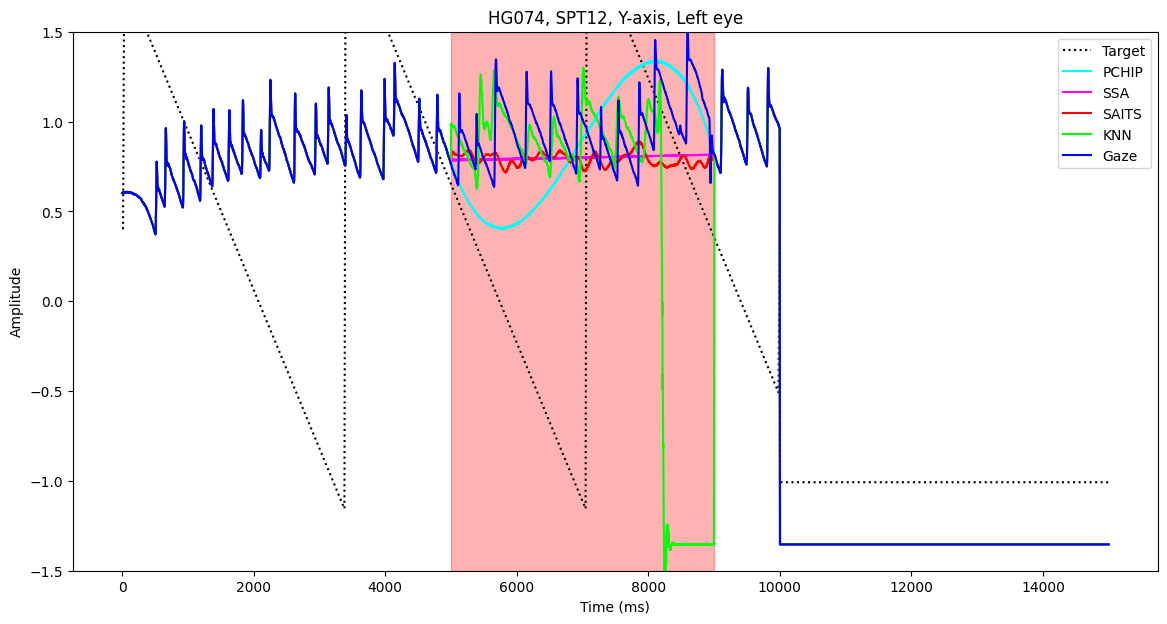

In [54]:
# plt.plot(oDATA[65])
# plt.plot(SAITS_refined_1[65])
zz = 575 # all_signals[5450] corresponds to instance 'HG074', smoothpur 12, signal 'Ly'.

plt.figure(figsize=(14, 7))
plt.plot(Targets_n[zz], label='Target', color='black', linestyle = 'dotted')
plt.plot(PCHIP_refined_1[zz], label='PCHIP', color='cyan')
plt.plot(SSA_refined_1[zz], label='SSA', color='fuchsia')
plt.plot(SAITS_refined_1[zz], label='SAITS',  color='red')
plt.plot(KNN_refined_1[zz], label='KNN',   color='lime')
plt.plot(flats_normalized[zz], label='Gaze', color='blue')

plt.axvspan(5000, 9000, color='red', alpha=0.3)

# Add labels and legend
plt.xlabel('Time (ms)')
plt.ylim(-1.5, 1.5)

plt.ylabel('Amplitude')
plt.title('HG074, SPT12, Y-axis, Left eye')
plt.legend()
plt.savefig('figure7.svg', format='svg')


plt.show()

In [55]:
eventL = pd.read_csv('Artificial_blinks/HG032_V2/SmoothPur_12/REvent.dat', header=None, names=['start', 'end', 'value'])
missing_ranges = eventL[eventL['value'] == 2].copy()


FileNotFoundError: [Errno 2] No such file or directory: 'Artificial_blinks/HG032_V2/SmoothPur_12/REvent.dat'

In [56]:
# Plot the sigL data
plt.figure(figsize=(14, 7))
plt.plot(Targets_n[5183], label='Target', color='black', linestyle = 'dotted')

plt.plot(PCHIP_refined[5183], label='PCHIP', color='cyan')
plt.plot(SSA_refined[5183], label='SSA', color='fuchsia')

plt.plot(flats_normalized[5183], label='Gaze', color='blue')



# Highlight the missing ranges
for idx, row in missing_ranges.iterrows():
    plt.axvspan(row['start'], row['end'], color='red', alpha=0.3)

# Add labels and legend
plt.xlabel('Time (ms)')
plt.ylim(-2, 2)

plt.ylabel('Amplitude')
plt.title('H032_v2, SPT12, Y-axis, Right eye')
plt.legend()
plt.savefig('figure1.svg', format='svg')

plt.show()

IndexError: index 5183 is out of bounds for axis 0 with size 576

<Figure size 1400x700 with 0 Axes>

In [57]:

# Plot the sigL data
plt.figure(figsize=(14, 7))
plt.plot(Targets_n[5183], label='Target', color='black', linestyle = 'dotted')
# plt.plot(PCHIP_refined[5183], label='PCHIP', color='red')

plt.plot(SAITS_refined[5183], label='SAITS', color='red')
plt.plot(flats_normalized[5183], label='Gaze', color='blue')

# Highlight the missing ranges
for idx, row in missing_ranges.iterrows():
    plt.axvspan(row['start'], row['end'], color='red', alpha=0.3)

# Add labels and legend
plt.xlabel('Time (ms)')
plt.ylim(-2, 2)

plt.ylabel('Amplitude')
plt.title('H032_v2, SPT12, Y-axis, Right eye')
plt.legend()
plt.savefig('figure2.svg', format='svg')

plt.show()

IndexError: index 5183 is out of bounds for axis 0 with size 576

<Figure size 1400x700 with 0 Axes>

In [58]:
oDATA1 = flats_normalized   ## original_data 
Target = Targets_n
SAITS_model = saits


imputation_method = 'SSA'
SSA_interpolated_2, SSA_refined_2 = Refinement_nan_pipeline(oDATA1, imputation_method, SAITS_model, Target, model, device)

imputation_method = 'Cubic'
PCHIP_interpolated_2, PCHIP_refined_2 = Refinement_nan_pipeline(oDATA1, imputation_method,SAITS_model, Target, model, device)

imputation_method = 'SAITS'
SAITS_interpolated_2, SAITS_refined_2 = Refinement_nan_pipeline(oDATA1, imputation_method,SAITS_model, Target, model, device)

imputation_method = 'KNN'
KNN_interpolated_2, KNN_refined_2 = Refinement_nan_pipeline(oDATA1, imputation_method,SAITS_model, Target, model, device)

C:\Users\uefav\AppData\Local\Temp\ipykernel_22060\1964639947.py:216: RuntimeWarning: invalid value encountered in divide
  reconstructed_series /= weight


KeyboardInterrupt: 

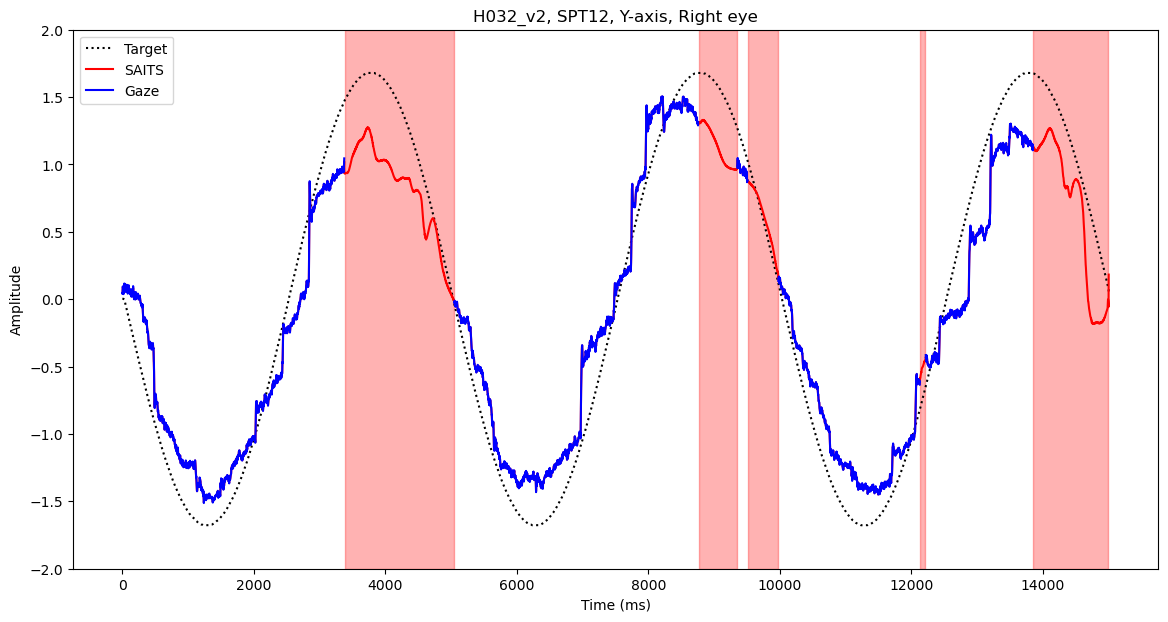

In [191]:

# Plot the sigL data
plt.figure(figsize=(14, 7))
plt.plot(Targets_n[5183], label='Target', color='black', linestyle = 'dotted')
# plt.plot(PCHIP_refined[5183], label='PCHIP', color='red')

plt.plot(SAITS_refined_2[5183], label='SAITS', color='red')
plt.plot(flats_normalized[5183], label='Gaze', color='blue')

# Highlight the missing ranges
for idx, row in missing_ranges.iterrows():
    plt.axvspan(row['start'], row['end'], color='red', alpha=0.3)

# Add labels and legend
plt.xlabel('Time (ms)')
plt.ylim(-2, 2)

plt.ylabel('Amplitude')
plt.title('H032_v2, SPT12, Y-axis, Right eye')
plt.legend()
plt.savefig('figure2.svg', format='svg')

plt.show()

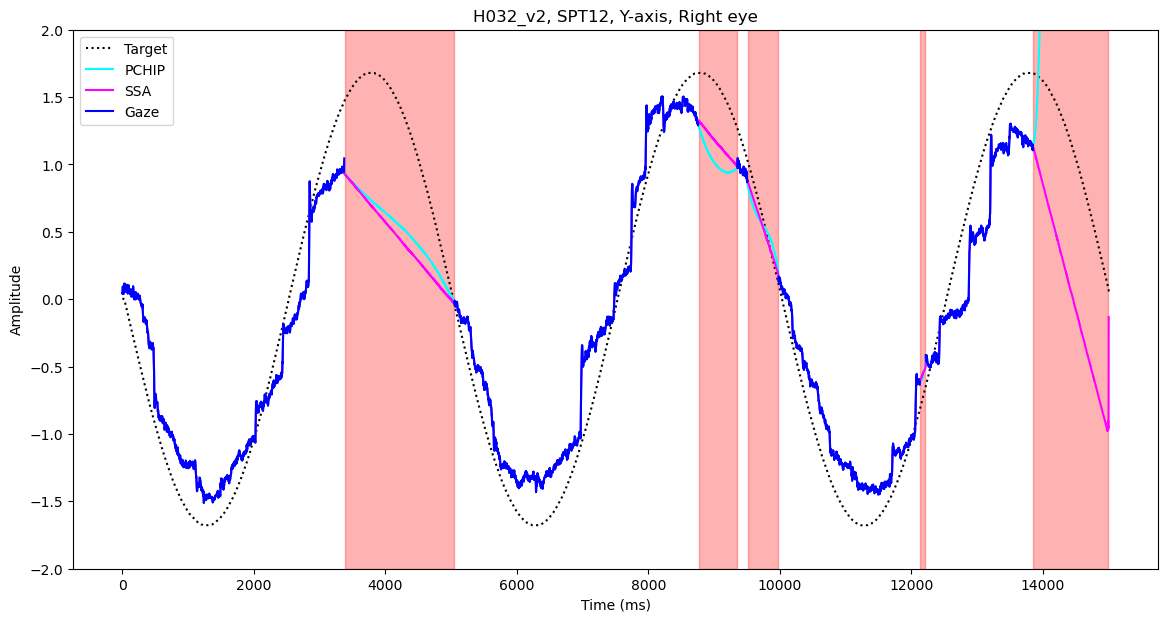

In [187]:
# Plot the sigL data
plt.figure(figsize=(14, 7))
plt.plot(Targets_n[5183], label='Target', color='black', linestyle = 'dotted')

plt.plot(PCHIP_refined_2[5183], label='PCHIP', color='cyan')
plt.plot(SSA_refined_2[5183], label='SSA', color='fuchsia')

plt.plot(flats_normalized[5183], label='Gaze', color='blue')



# Highlight the missing ranges
for idx, row in missing_ranges.iterrows():
    plt.axvspan(row['start'], row['end'], color='red', alpha=0.3)

# Add labels and legend
plt.xlabel('Time (ms)')
plt.ylim(-2, 2)

plt.ylabel('Amplitude')
plt.title('H032_v2, SPT12, Y-axis, Right eye')
plt.legend()
plt.savefig('figure1.svg', format='svg')

plt.show()

In [ ]:
instance = 91

plt.figure(figsize=(10, 6))
plt.plot(downs[4659], label='Original', linewidth=3)
plt.plot(reshaped_results_all[4659], label='Imputed', linestyle='-', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Imputed vs. Original Time Series {instances_dict[str(instance)]}')
plt.legend()
plt.show()

In [209]:
Targets_n_d = downsample(Targets_n, 500)


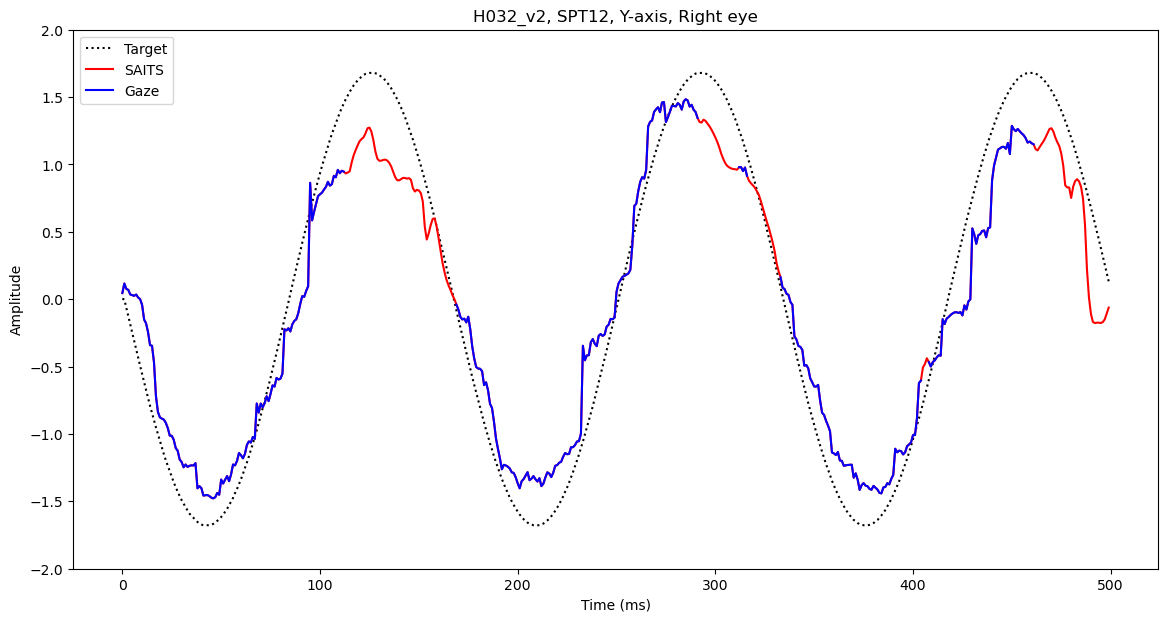

In [211]:
# Plot the sigL data
plt.figure(figsize=(14, 7))
plt.plot(Targets_n_d[5183], label='Target', color='black', linestyle = 'dotted')
# plt.plot(PCHIP_refined[5183], label='PCHIP', color='red')

plt.plot(reshaped_results_all[5183], label='SAITS', color='red')
plt.plot(downs[5183], label='Gaze', color='blue')

# # Highlight the missing ranges
# for idx, row in missing_ranges.iterrows():
#     plt.axvspan(row['start'], row['end'], color='red', alpha=0.3)

# Add labels and legend
plt.xlabel('Time (ms)')
plt.ylim(-2, 2)

plt.ylabel('Amplitude')
plt.title('H032_v2, SPT12, Y-axis, Right eye')
plt.legend()
plt.savefig('figure2_3.svg', format='svg')

plt.show()

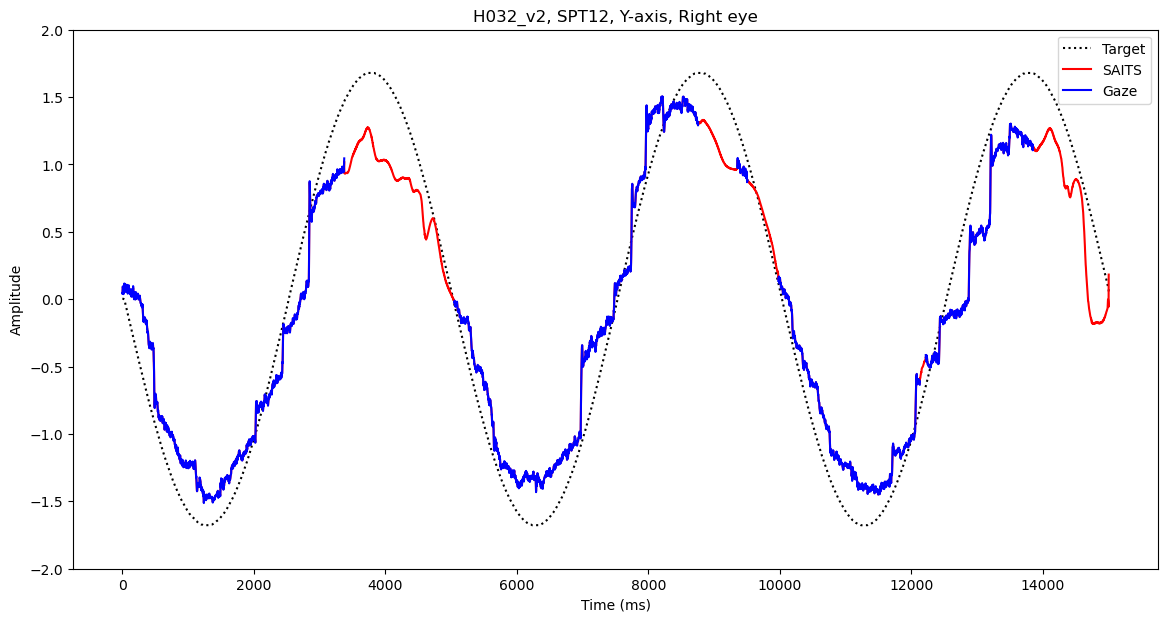

In [213]:
# Plot the sigL data
plt.figure(figsize=(14, 7))
plt.plot(Targets_n[5183], label='Target', color='black', linestyle = 'dotted')
# plt.plot(PCHIP_refined[5183], label='PCHIP', color='red')

plt.plot(SAITS_refined_2[5183], label='SAITS', color='red')
# plt.plot(SAITS_interpolated_2[5183], label='SAITS')

plt.plot(flats_normalized[5183], label='Gaze', color='blue')

# # Highlight the missing ranges
# for idx, row in missing_ranges.iterrows():
#     plt.axvspan(row['start'], row['end'], color='red', alpha=0.3)

# Add labels and legend
plt.xlabel('Time (ms)')
plt.ylim(-2, 2)

plt.ylabel('Amplitude')
plt.title('H032_v2, SPT12, Y-axis, Right eye')
plt.legend()
plt.savefig('figure2_4.svg', format='svg')

plt.show()